## Parallelization layout specification

This notebook explains how layouts can be specified for parallelization with the `qc_parallelizer`
module to force certain virtual qubits onto certain physical qubits. It is assumed that you already
understand what the parallelizer is for and have it installed. If you do not, see the
[introduction notebook](./parallel-circuits-introduction.ipynb).

### Required modules

We begin by importing various modules that we will use in this notebook.

In [1]:
import iqm.qiskit_iqm as iqm
import matplotlib.pyplot as plt
import qc_parallelizer as parallelizer
import qiskit
from helpers import patch_qiskit_iqm, plot_circuits, plot_histograms, plot_layouts

patch_qiskit_iqm()  # ignore

### Circuits and backends

As an illustrative example, we will use one simple circuit with just one gate, and one two-qubit
Bell state circuit. For the backend, we will use a simulated version of IQM's 5-qubit Adonis
architecture.

We will then define a layout for the first circuit that places it on QB3, which should push the two
circuits into separate host circuits.

> **Why?** QB3 is the central qubit in a star topology on Adonis. Circuits with two-qubit operations
  _need_ the central qubit since all couplers connect to it. Thus, if we force another circuit to
  use it, the circuit that needs it will be placed elsewhere.

First, we will define and plot the circuits.

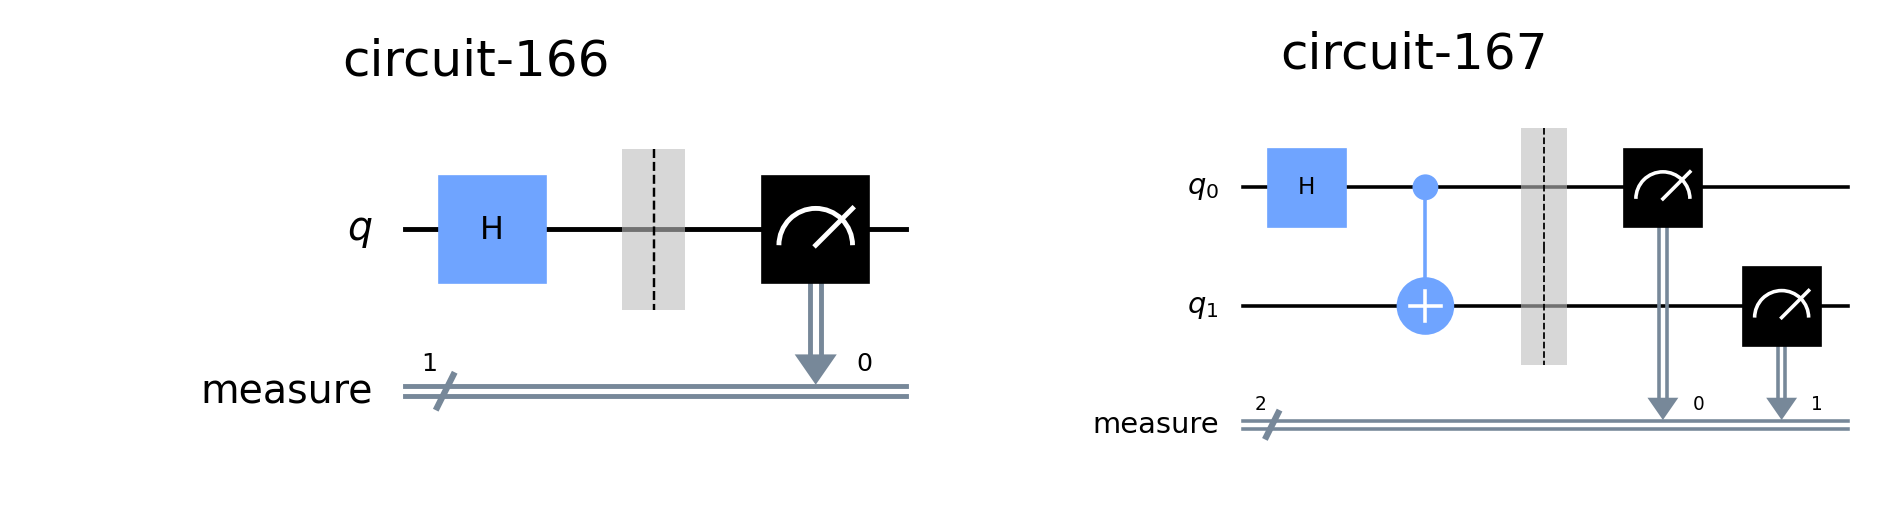

In [2]:
circuits = [qiskit.QuantumCircuit(1)] + [qiskit.QuantumCircuit(2)]
for circuit in circuits:
    circuit.h(0)
    if circuit.width() > 1:
        circuit.cx(0, 1)
    circuit.measure_active()

plot_circuits(circuits)

We'll also need an object that represents the backend.

In [3]:
backend = iqm.IQMFakeAdonis()
print(f"Backend has {backend.num_qubits} qubits.")

Backend has 5 qubits.


Let's see how the circuits would be placed with no layout information.

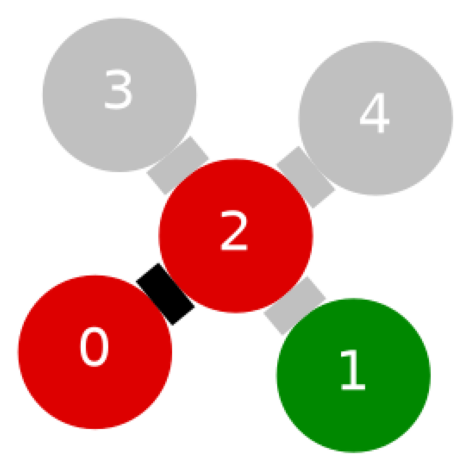

In [4]:
rearranged = parallelizer.rearrange(circuits, backend)
parallelizer.visualization.plot_placements(rearranged)

The circuits were placed on the same host circuit. This is efficient, but next, we will force the
single-qubit circuit (green) in the middle (qubit 2).

### Defining layouts

Layout specification is simple: you can pass a list or a dict where indices or keys represent
virtual qubit indices and values represent physical qubit indices. We will use a dict.

In [5]:
circuits_with_layouts = [
    (circuits[0], {0: 2}),  # For this circuit, virt. qubit 0 must be placed on phys. qubit 2.
    circuits[1],  # This circuit has no layout.
]

### Applying the layouts

We run the same code as above, but now with layouts:

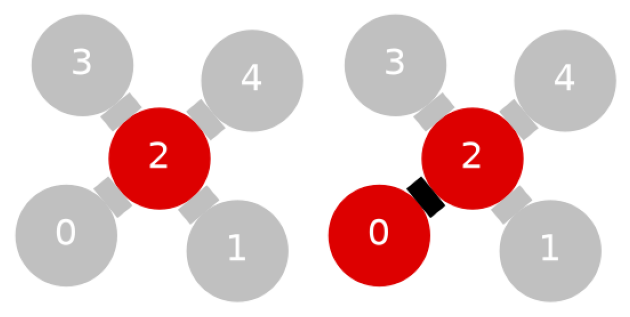

In [6]:
rearranged = parallelizer.rearrange(circuits_with_layouts, backend)
parallelizer.visualization.plot_placements(rearranged)

As expected, the circuits were forced onto different host circuits, since one uses QB3 as defined in
its layout and the other requires it due to coupling constraints.

### Results

Finally, to conclude this demonstration, let us run the circuits and verify that the results are
what we expect.

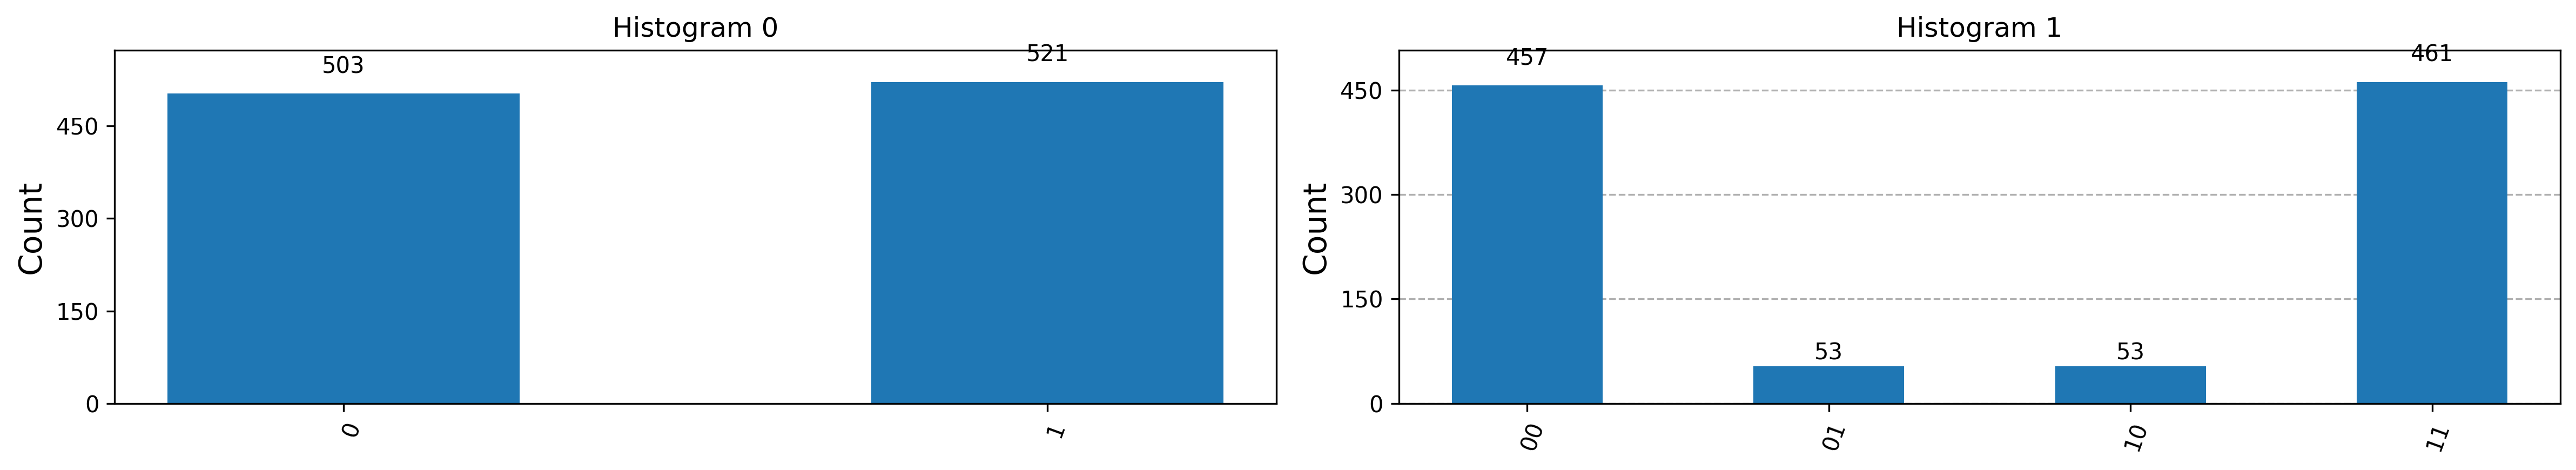

In [7]:
job = parallelizer.execute(rearranged)
results = job.results()
plot_histograms([result.get_counts() for result in results], figsize=(16, 3))